In [1]:
# All imports
from regression_analysis.utils import create_data_franke, create_plots
from regression_analysis.fit_model import ordinary_least_squares

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

# Ordinary Least Squares

This notebook explains the Ordinary Least Squares (OLS) method. 

The Franke function is used to produce the data:

$$y(x_1,x_2) = \frac{3}{4}\exp{(-\frac{(9x_1-2)^2}{4}-\frac{(9x_2-2)^2}{4})} + \frac{3}{4}\exp{(-\frac{(9x_1+1)^2}{49}-\frac{(9x_2+1)}{10})} + \frac{1}{2}\exp{(-\frac{(9x_1-7)^2}{4}-\frac{(9x_2-3)^2}{4})} - \frac{1}{5}\exp{(-(9x_1-4)^2-(9x_2-7)^2 )}$$

and $x_1, x_2 \in [0,1]$.




## Plot Franke function

<IPython.core.display.Javascript object>


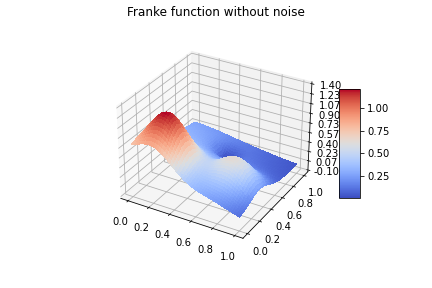

<IPython.core.display.Javascript object>


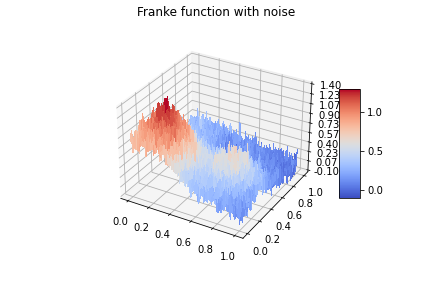

In [10]:
%matplotlib notebook

# Generate data without noise
x1, x2, y = create_data_franke.generate_data(noisy=False, points=100)

# Generate data with noise
_, _, y_noise = create_data_franke.generate_data(noisy=True, noise_variance=0.1, points=100)

# Plot data
create_plots.make_3d_surface_plot(x1, x2, y, title="Franke function without noise")
create_plots.make_3d_surface_plot(x1, x2, y_noise, title="Franke function with noise")

## Calculate Ordinary Least Squares for order 1
We want to find the best $\beta_{OLS}$ such that $\tilde{y}=D\beta_{OLS}$ where $D$ is the design matrix. $D$'s columns are different combination of the input variables $x_1$ and $x_2$. 
For example when we want to fit a plynomial with the order 2 to $y$ the design matrix has the columns: $1, x, y, xy, x^2, y^2$. The parameter $\beta_{OLS}$ is defined as: $$\beta_{OLS}:= (D^T D)^{-1}D^T y$$

[ 0.98860268 -0.66594379 -0.50052864]


<IPython.core.display.Javascript object>


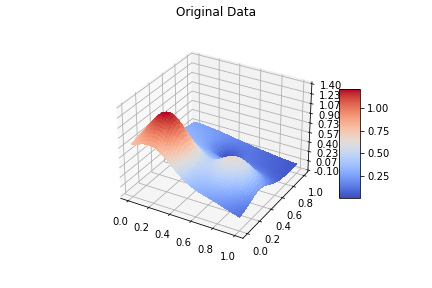

<IPython.core.display.Javascript object>


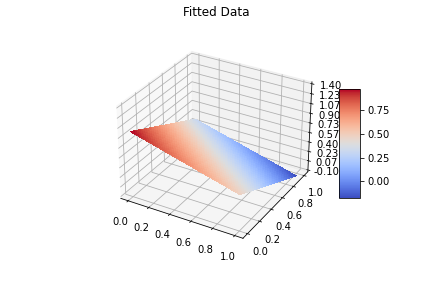

In [11]:
# Calculate beta and the response variable y_tilde for ordinary least squares.
beta_OLS, y_tilde_OLS = ordinary_least_squares.calculate_OLS(x1, x2, y, order=1)
print(beta_OLS)

# Plot y_tilde
create_plots.make_3d_surface_plot(x1, x2, y, title="Original Data")
create_plots.make_3d_surface_plot(x1, x2, y_tilde_OLS, title="Fitted Data")

## Perform OLS for several orders

noise=False, train_frac=0.8,cross_val=False, num_fold=0, bootstrap=False 

MSE train data: [[0.01816346 0.00916122 0.00592042 0.0022251  0.00144164]]
MSE test data: [[0.00784541 0.12495534 0.01907661 0.12519578 0.22440675]]
R2 train data: [[0.66740039 0.83224463 0.89158847 0.95925521 0.97360148]]
R2 test data: [[-0.27847392 -0.14097841 -0.1880152  -0.9612127  -0.83075929]]


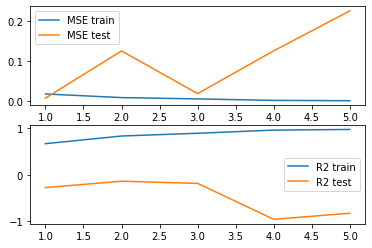

In [12]:
%matplotlib inline

# Fit model for different polynomial
max_order = 5
orders = range(1, max_order+1)
MSE_train = np.empty([1, max_order])
R2_train = np.empty([1, max_order])
MSE_test = np.empty([1, max_order])
R2_test = np.empty([1, max_order])

for i, order in enumerate(orders):
    _, _, _, MSE_train[:, i], MSE_test[:, i], R2_train[:, i], R2_test[:, i] = ordinary_least_squares.perform_OLS(x1, x2, y, order,
                                                                                                                 train_frac=0.8,
                                                                                                                 cross_val=False,
                                                                                                                 num_fold=0,
                                                                                                                 bootstrap=False)

# Plot errors
axes_1 = np.array(orders)
args = (MSE_train, MSE_test, R2_train, R2_test)
axes_2 = np.concatenate(args, axis=0)

line_lab = ['MSE train', 'MSE test', 'R2 train', 'R2 test']

fig_errors = plt.figure()
create_plots.make_multi_line_plot(axes_1, axes_2[:2, :], line_lab[:2], fig_errors, 211)
create_plots.make_multi_line_plot(axes_1, axes_2[2:, :], line_lab[2:], fig_errors, 212)

print("noise=False, train_frac=0.8,cross_val=False, num_fold=0, bootstrap=False \n")
print("MSE train data: " +  str(MSE_train))
print("MSE test data: " +  str(MSE_test))
print("R2 train data: " +  str(R2_train))
print("R2 test data: " +  str(R2_test))

## Multiple Orders

Start by defining a function which creates a heatmap from a pandas dataframe.

In [14]:
def create_heatmap(data, axis, title=None):
    """
    Creates a heatmap from a pandas dataframe.
    Inspired by: https://www.geeksforgeeks.org/display-the-pandas-dataframe-in-heatmap-style/
    """
    # Reverse order of dataframe index
    data = data.sort_index(ascending=False)
    # Displaying dataframe as an heatmap
    sns.heatmap(data, linewidths = 0.30, annot = True, cmap="mako", ax=axis, vmin=0.001, vmax=0.02).set_title(title)

### Influence of the number of folds when using cross-validation

In [15]:
# Fit model for different polynomial orders and different amount of folds
max_order = 5
orders = range(1, max_order+1)

cross_val_folds = range(5, 11)

MSE_train = np.empty([len(cross_val_folds), max_order])
MSE_test = np.empty([len(cross_val_folds), max_order])


for folds_idx, n_folds in enumerate(cross_val_folds):
    for order_idx, order in enumerate(orders):
        _, _, _, MSE_train[folds_idx, order_idx], MSE_test[folds_idx, order_idx], _, _ = ordinary_least_squares.perform_OLS(x1, x2, y, order,
                                                                                                                            train_frac=0.8,
                                                                                                                            cross_val=True,
                                                                                                                            num_fold=n_folds,
                                                                                                                            bootstrap=False)
MSE_train_cross_df = pd.DataFrame(data=MSE_train, index=cross_val_folds, columns=orders)
MSE_test_cross_df = pd.DataFrame(data=MSE_test, index=cross_val_folds, columns=orders)

print("MSE training data:")
display(MSE_train_cross_df)
print("MSE test data:")
display(MSE_test_cross_df)

MSE training data:


,1,2,3,4,5
5,0.015173,0.011541,0.005196,0.002437,0.001300
6,0.016380,0.011242,0.005207,0.002724,0.001343
7,0.015569,0.010823,0.005230,0.002742,0.001318
8,0.016458,0.011479,0.005004,0.002705,0.001436
9,0.016024,0.011621,0.005179,0.002785,0.001332
10,0.015487,0.011449,0.005311,0.002802,0.001372


MSE test data:


,1,2,3,4,5
5,0.018119,0.011582,0.005566,0.004450,0.001951
6,0.012910,0.012914,0.005586,0.003008,0.001730
7,0.016807,0.015928,0.005400,0.002945,0.001979
8,0.010770,0.011508,0.007109,0.003176,0.001205
9,0.013453,0.010362,0.006085,0.002486,0.002019
10,0.018119,0.011776,0.004758,0.002299,0.001773


### Influence of train fraction

In [19]:
# Fit model for different polynomial orders and different train fractions, no boostrapping
max_order = 5
orders = range(1, max_order+1)

train_frac = np.round(np.arange(0.75, 1, 0.05),2)

MSE_train = np.empty([len(train_frac), max_order])
MSE_test = np.empty([len(train_frac), max_order])


for frac_idx, frac in enumerate(train_frac):
    for order_idx, order in enumerate(orders):
        _, _, _, MSE_train[frac_idx, order_idx], MSE_test[frac_idx, order_idx], _, _ = ordinary_least_squares.perform_OLS(x1, x2, y, order,
                                                                                                                            train_frac=frac,
                                                                                                                            cross_val=False,
                                                                                                                            num_fold=0,
                                                                                                                            bootstrap=False)
MSE_train_frac_df = pd.DataFrame(data=MSE_train, index=train_frac, columns=orders)
MSE_test_frac_df = pd.DataFrame(data=MSE_test, index=train_frac, columns=orders)

print("MSE training data:")
display(MSE_train_frac_df)
print("MSE test data:")
display(MSE_test_frac_df)

MSE training data:


,1,2,3,4,5
0.75,0.018752,0.008527,0.006117,0.002067,0.001461
0.80,0.018163,0.009161,0.005920,0.002225,0.001442
0.85,0.017461,0.009873,0.005686,0.002352,0.001435
0.90,0.016764,0.010568,0.005445,0.002484,0.001429
0.95,0.016186,0.011128,0.005283,0.002627,0.001416


MSE test data:


,1,2,3,4,5
0.75,0.008097,0.187370,0.019383,0.353824,0.466008
0.80,0.007845,0.124955,0.019077,0.125196,0.224407
0.85,0.008116,0.079288,0.017169,0.049932,0.070725
0.90,0.008334,0.047687,0.014008,0.021626,0.018715
0.95,0.008220,0.027830,0.009766,0.009522,0.004935


In [17]:
# Fit model for different polynomial orders and different train fractions, with boostrapping
max_order = 5
orders = range(1, max_order+1)

train_frac = np.round(np.arange(0.75, 1, 0.05),2)

MSE_train = np.empty([len(train_frac), max_order])
MSE_test = np.empty([len(train_frac), max_order])


for frac_idx, frac in enumerate(train_frac):
    for order_idx, order in enumerate(orders):
        _, _, _, MSE_train[frac_idx, order_idx], MSE_test[frac_idx, order_idx], _, _ = ordinary_least_squares.perform_OLS(x1, x2, y, order,
                                                                                                                            train_frac=frac,
                                                                                                                            cross_val=False,
                                                                                                                            num_fold=0,
                                                                                                                            bootstrap=True)
MSE_train_frac_boot_df = pd.DataFrame(data=MSE_train, index=train_frac, columns=orders)
MSE_test_frac_boot_df = pd.DataFrame(data=MSE_test, index=train_frac, columns=orders)

print("MSE training data:")
display(MSE_train_frac_boot_df)
print("MSE test data:")
display(MSE_test_frac_boot_df)

MSE training data:


,1,2,3,4,5
0.75,0.018412,0.008827,0.006159,0.002048,0.001419
0.80,0.018834,0.009307,0.005865,0.002211,0.001416
0.85,0.017168,0.010119,0.005731,0.002387,0.001427
0.90,0.016456,0.010752,0.005407,0.002509,0.001437
0.95,0.016218,0.011114,0.005281,0.002567,0.001363


MSE test data:


,1,2,3,4,5
0.75,0.008226,0.186229,0.015419,0.362929,0.477408
0.80,0.007995,0.122812,0.017351,0.137871,0.251795
0.85,0.008340,0.079725,0.016540,0.050933,0.077525
0.90,0.008006,0.047794,0.013121,0.022101,0.018152
0.95,0.007938,0.028693,0.009721,0.009896,0.005615


Make comparison between different sampling methods

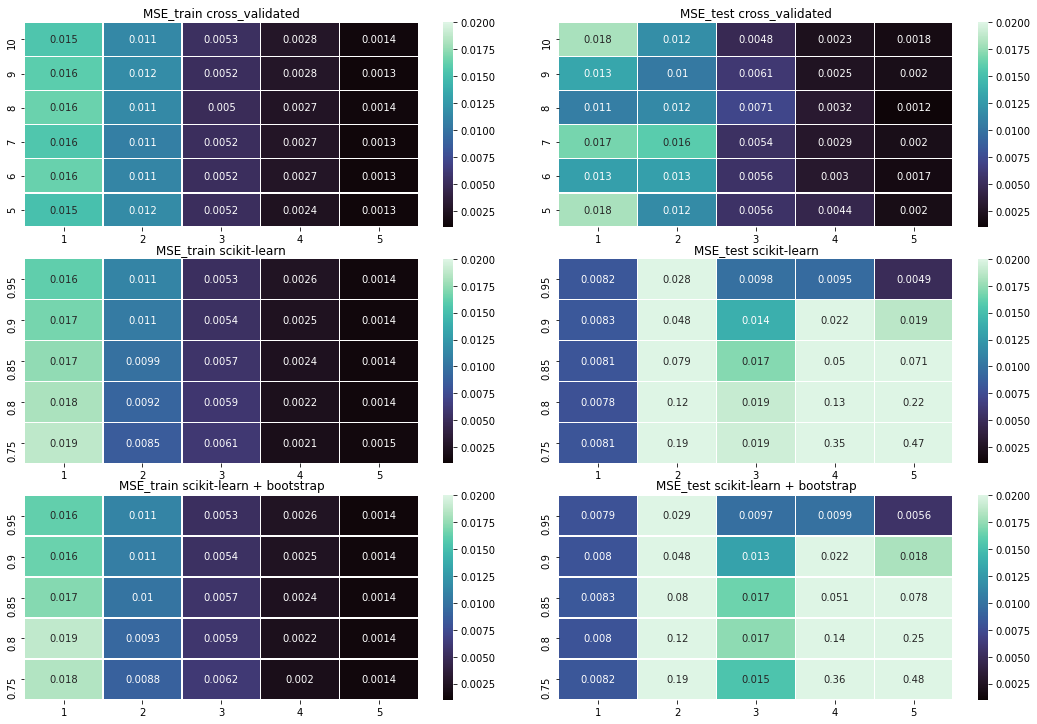

In [20]:
%matplotlib inline

fig, ax = plt.subplots(3,2,figsize=(15,10))
fig.tight_layout()

# Cross-validated data
create_heatmap(MSE_train_cross_df, title="MSE_train cross_validated", axis=ax[0][0])
create_heatmap(MSE_test_cross_df, title="MSE_test cross_validated", axis=ax[0][1])

# Sklearn splitting in train9ing and testing data (without bootstrap)
create_heatmap(MSE_train_frac_df, title="MSE_train scikit-learn", axis=ax[1][0])
create_heatmap(MSE_test_frac_df, title="MSE_test scikit-learn", axis=ax[1][1])

# Sklearn splitting in train9ing and testing data (without bootstrap)
create_heatmap(MSE_train_frac_boot_df, title="MSE_train scikit-learn + bootstrap", axis=ax[2][0])
create_heatmap(MSE_test_frac_boot_df, title="MSE_test scikit-learn + bootstrap", axis=ax[2][1])